# Task 1: Acquire, Preproess and Analyze Data


## Import libraries and data



In [92]:
import pandas as pd
pd.set_option('display.max_rows', 700)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GroupShuffleSplit

In [93]:
searchTrendData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv")
hospitalizationData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv")

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean the Dataframe

In [94]:
searchTrendData

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,date,symptom:Abdominal obesity,symptom:Abdominal pain,...,symptom:Wart,symptom:Water retention,symptom:Weakness,symptom:Weight gain,symptom:Wheeze,symptom:Xeroderma,symptom:Xerostomia,symptom:Yawn,symptom:hyperhidrosis,symptom:pancreatitis
0,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.28,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-13,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.26,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-20,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.48,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-01-27,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.93,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.93,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.05,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-17,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.62,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-02-24,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.42,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-02,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.30,NaN,NaN
9,US-AK,US,United States,Alaska,US-AK,NaN,NaN,2020-03-09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.77,NaN,NaN


There are columns in the dataframe where the whole column contains nothing but NaN, 
so these columns need to be dropped. 

Then there are columns that contains a large
amount of NaNs. These should be dropped too once the amount of NaN reaches a certain
threshold. Several experimentation were performed to decide the best value for this
threshold. The higher the threshold, the more columns dropped. 

In [95]:
## drop all NaN columns for searchTrendData
searchTrendData = searchTrendData.dropna('columns', 'all')
## drop column if it doesn't have at least 60% of non-NaN values
searchTrendData = searchTrendData.dropna(axis = "columns", thresh = (int) (searchTrendData.shape[0] * 0.6))

## drop all data that is not from the US
hospitalizationData = hospitalizationData[hospitalizationData['open_covid_region_code'].str.contains('US-')]
## drop all NaN columns for hospitalizationData
hospitalizationData = hospitalizationData.dropna('columns', 'all')
## drop the column if it doesn't have at least 30% of non-Nan values 
hospitalizationData = hospitalizationData.dropna(axis = "columns", thresh = (int) (hospitalizationData.shape[0] * 0.3))

In [5]:
searchTrendData.columns

Index(['open_covid_region_code', 'country_region_code', 'country_region',
       'sub_region_1', 'sub_region_1_code', 'date',
       'symptom:Angular cheilitis', 'symptom:Aphonia',
       'symptom:Burning Chest Pain', 'symptom:Crackles',
       'symptom:Dysautonomia', 'symptom:Hemolysis', 'symptom:Laryngitis',
       'symptom:Myoclonus', 'symptom:Rectal pain', 'symptom:Rumination',
       'symptom:Shallow breathing', 'symptom:Stridor',
       'symptom:Urinary urgency', 'symptom:Ventricular fibrillation',
       'symptom:Viral pneumonia'],
      dtype='object')

## Normalize Search Trend Data
Search Trend dataset used an unknown normalization constant to divide the raw values of search trends. 
This consntant is the same for all data from the same region, but different for each region.
This normalization makes comparing search trends of a symptom across different regions directly semantically wrong.
To fix this issue, the search trend data need to be renormalized.

The re-normalization strategy chosen here is to convert search trend data to its porportion of the median.
The median is chosen across all dates and all symptoms in one region, therefore there is one median for every region.
Since the amount of weeks, and the number of symptoms isfixed across all regions, the number of data each state has is the same. 
Therefore, each state weighs equally.

The median chosen this way represents the median frequency of searches of any COVID-19 related symptoms people do within a specific region.
Divisive normalization using these medians gives a result that represents how frequently people search for this symptom.

For example, US-AK has a median of 8.27. Normalizing its data we get 1.51 for Aphonia in the week of 2020-02-03, 0.92 in the week of 2020-01-27, 
for Angular cheilitis 0.90 in the week of 2020-01-27, and 0.97 in the week of 2020-02-03. 
The intepretation is: In the week of 2020-01-27, people search for Aphonia more than Angular cheilitis, therefore Aphonia is more popular than Angular Cheilitis.
In the week of 2020-02-03, people search for Aphonia more frequently than in the week of 2020-01-27, therefore Aphonia is more popular in the week of 2020-02-03 than in the week of 2020-01-27.


In [96]:
## find all symptoms
symptoms = []
for column in searchTrendData.columns:
    if 'symptom' in column:
        symptoms.append(column)

## find all regions
regions = searchTrendData['open_covid_region_code'].unique()

## iterate through all symptoms
for region in regions:
    ## concatenate all symptom data
    concatenation = []
    for symptom in symptoms:
        ## print(region, symptom, searchTrendData[searchTrendData['open_covid_region_code'] == region][symptom].fillna(0).tolist())
        concatenation += (searchTrendData[searchTrendData['open_covid_region_code'] == region][symptom].dropna().tolist())
    
    ## find median for this region
    median = np.median(concatenation)
    ## divde data by median
    for symptom in symptoms:
        ## print("normalizaing ", region, symptom, " with median ", median)
        searchTrendData.loc[searchTrendData['open_covid_region_code'] == region, symptom] = searchTrendData[searchTrendData['open_covid_region_code'] == region][symptom].div(median)

normalizaing  US-AK symptom:Angular cheilitis  with median  8.27
normalizaing  US-AK symptom:Aphonia  with median  8.27
normalizaing  US-AK symptom:Burning Chest Pain  with median  8.27
normalizaing  US-AK symptom:Crackles  with median  8.27
normalizaing  US-AK symptom:Dysautonomia  with median  8.27
normalizaing  US-AK symptom:Hemolysis  with median  8.27
normalizaing  US-AK symptom:Laryngitis  with median  8.27
normalizaing  US-AK symptom:Myoclonus  with median  8.27
normalizaing  US-AK symptom:Rectal pain  with median  8.27
normalizaing  US-AK symptom:Rumination  with median  8.27
normalizaing  US-AK symptom:Shallow breathing  with median  8.27
normalizaing  US-AK symptom:Stridor  with median  8.27
normalizaing  US-AK symptom:Urinary urgency  with median  8.27
normalizaing  US-AK symptom:Ventricular fibrillation  with median  8.27
normalizaing  US-AK symptom:Viral pneumonia  with median  8.27
normalizaing  US-DC symptom:Angular cheilitis  with median  4.055
normalizaing  US-DC sympt

In [41]:
## searchTrendData[searchTrendData['open_covid_region_code'] == region][symptom] = searchTrendData[searchTrendData['open_covid_region_code'] == region][symptom].div(median)
searchTrendData

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,1.007255,...,1.102781,1.749698,1.270859,NaN,1.654172,NaN,1.246675,NaN,1.198307,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,0.993954,...,NaN,1.363966,1.016929,1.016929,NaN,NaN,1.873035,0.925030,1.016929,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,1.001209,...,NaN,1.980653,0.934704,0.956469,1.690447,NaN,1.801693,0.911729,1.957678,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,0.903265,0.925030,NaN,1.256348,...,1.079807,1.366385,NaN,1.168077,1.233374,NaN,1.828295,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,0.974607,1.518742,0.906892,1.246675,...,NaN,1.926239,1.518742,NaN,1.269649,NaN,1.382104,NaN,1.291415,1.269649
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,1.315599,NaN,1.382104,...,1.140266,1.272068,NaN,1.644498,1.074970,0.921403,1.557437,0.899637,NaN,0.943168
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,1.107618,NaN,1.107618,...,NaN,1.025393,1.128174,0.984281,0.881499,NaN,1.538089,NaN,1.045949,1.025393
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,1.282950,0.881499,NaN,1.082225,...,1.021765,1.482467,NaN,1.282950,1.201935,NaN,1.122128,0.862152,1.042322,1.342201
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,0.802902,NaN,...,0.844015,1.145103,0.802902,0.984281,0.844015,NaN,1.506651,NaN,1.264813,1.707376
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,0.956469,NaN,NaN,...,NaN,1.505441,0.854897,0.854897,1.037485,0.977025,1.689238,NaN,NaN,2.279323


Merge two dataset

In [8]:
## debug cell, delete when assignment is finished
searchTrendData
##len(searchTrendData[searchTrendData['open_covid_region_code'] == 'US-WY'])

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,1.007255,...,1.102781,1.749698,1.270859,NaN,1.654172,NaN,1.246675,NaN,1.198307,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,0.993954,...,NaN,1.363966,1.016929,1.016929,NaN,NaN,1.873035,0.925030,1.016929,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,1.001209,...,NaN,1.980653,0.934704,0.956469,1.690447,NaN,1.801693,0.911729,1.957678,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,0.903265,0.925030,NaN,1.256348,...,1.079807,1.366385,NaN,1.168077,1.233374,NaN,1.828295,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,0.974607,1.518742,0.906892,1.246675,...,NaN,1.926239,1.518742,NaN,1.269649,NaN,1.382104,NaN,1.291415,1.269649
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,1.315599,NaN,1.382104,...,1.140266,1.272068,NaN,1.644498,1.074970,0.921403,1.557437,0.899637,NaN,0.943168
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,1.107618,NaN,1.107618,...,NaN,1.025393,1.128174,0.984281,0.881499,NaN,1.538089,NaN,1.045949,1.025393
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,1.282950,0.881499,NaN,1.082225,...,1.021765,1.482467,NaN,1.282950,1.201935,NaN,1.122128,0.862152,1.042322,1.342201
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,0.802902,NaN,...,0.844015,1.145103,0.802902,0.984281,0.844015,NaN,1.506651,NaN,1.264813,1.707376
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,0.956469,NaN,NaN,...,NaN,1.505441,0.854897,0.854897,1.037485,0.977025,1.689238,NaN,NaN,2.279323


In [9]:
# searchTrendData.iloc[7:10, :]

In [10]:
## debug cell, delete when assignment is finished
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')
## Feiyang Li --> Once you changed hospitalization data to weekly resolution, there are many duplicates. Let's drop them
## and see how it works
## 
hospitalizationData = hospitalizationData.drop_duplicates();
hospitalizationData

,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
83900,US-WY,Wyoming,2020-03-02,0.0,0.0
83902,US-WY,Wyoming,2020-03-09,0.0,0.0
83909,US-WY,Wyoming,2020-03-16,0.0,0.0
83916,US-WY,Wyoming,2020-03-23,0.0,0.0
83920,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
96686,US-AK,Alaska,2020-09-14,0.0,0.0
96693,US-AK,Alaska,2020-09-21,0.0,0.0
96700,US-AK,Alaska,2020-09-28,0.0,0.0
96707,US-AK,Alaska,2020-10-05,0.0,0.0


In [11]:
hospitalizationData
# len(hospitalizationData[hospitalizationData['open_covid_region_code'] == 'US-WY'])

,open_covid_region_code,region_name,date,hospitalized_cumulative,hospitalized_new
83900,US-WY,Wyoming,2020-03-02,0.0,0.0
83902,US-WY,Wyoming,2020-03-09,0.0,0.0
83909,US-WY,Wyoming,2020-03-16,0.0,0.0
83916,US-WY,Wyoming,2020-03-23,0.0,0.0
83920,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
96686,US-AK,Alaska,2020-09-14,0.0,0.0
96693,US-AK,Alaska,2020-09-21,0.0,0.0
96700,US-AK,Alaska,2020-09-28,0.0,0.0
96707,US-AK,Alaska,2020-10-05,0.0,0.0


In [12]:
## change dates to weekly represented dates
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')

## drop the hospitalized_culumative column since it doesn't make since to merge them into a weekly entry
hospitalizationData = hospitalizationData.drop('hospitalized_cumulative', axis = 1)

## combine all data with the same region code, and the same date
## find all unique dates and regions
region_codes = hospitalizationData['open_covid_region_code'].unique()

result_df = pd.DataFrame()
## group all rows with the same region code
for code in region_codes:
    region_rows = hospitalizationData.groupby(['open_covid_region_code']).get_group(code)
    ## group these rows again by dates
    dates = region_rows['date'].unique()
    for date in dates:
        region_data = region_rows.groupby('date').get_group(date)

        ## combine all these entries into one row additively
        result_row = region_data.head(1)
        for r in range(1, region_data.shape[0]):
            for i in range(3, result_row.shape[1]):
                current_column = result_row.columns[i]
                result_row[current_column] += region_data.iloc[r][current_column]
        result_df = result_df.append(result_row)
    print(result_row)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code region_name       date  hospitalized_new
84119                  US-WY     Wyoming 2020-10-12              37.0
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code    region_name       date  hospitalized_new
84346                  US-WV  West Virginia 2020-10-12               0.0
/opt/venv/

In [13]:
result_df.reset_index(inplace = True)
result_df


,index,open_covid_region_code,region_name,date,hospitalized_new
0,83900,US-WY,Wyoming,2020-03-02,0.0
1,83902,US-WY,Wyoming,2020-03-09,0.0
2,83909,US-WY,Wyoming,2020-03-16,0.0
3,83916,US-WY,Wyoming,2020-03-23,15.0
4,83923,US-WY,Wyoming,2020-03-30,8.0
...,...,...,...,...,...
1852,96686,US-AK,Alaska,2020-09-14,0.0
1853,96693,US-AK,Alaska,2020-09-21,0.0
1854,96700,US-AK,Alaska,2020-09-28,0.0
1855,96707,US-AK,Alaska,2020-10-05,0.0


In [56]:
## this should merge two dataframe without duplicates
searchTrendData['date'] = pd.to_datetime(searchTrendData['date'])
result_df['date'] = pd.to_datetime(result_df['date'])
mergedData = searchTrendData.merge(result_df, on = ['open_covid_region_code', 'date'], how = 'left');
mergedData
#do we want to do outer merge or do we want to do inner join based on date and open_covid_region_code

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,index,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,1.007255,...,NaN,1.654172,NaN,1.246675,NaN,1.198307,NaN,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,0.993954,...,1.016929,NaN,NaN,1.873035,0.925030,1.016929,NaN,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,1.001209,...,0.956469,1.690447,NaN,1.801693,0.911729,1.957678,NaN,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,0.903265,0.925030,NaN,1.256348,...,1.168077,1.233374,NaN,1.828295,NaN,NaN,NaN,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,0.974607,1.518742,0.906892,1.246675,...,NaN,1.269649,NaN,1.382104,NaN,1.291415,1.269649,NaN,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,1.315599,NaN,1.382104,...,1.644498,1.074970,0.921403,1.557437,0.899637,NaN,0.943168,NaN,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,1.107618,NaN,1.107618,...,0.984281,0.881499,NaN,1.538089,NaN,1.045949,1.025393,NaN,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,1.282950,0.881499,NaN,1.082225,...,1.282950,1.201935,NaN,1.122128,0.862152,1.042322,1.342201,NaN,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,0.802902,NaN,...,0.984281,0.844015,NaN,1.506651,NaN,1.264813,1.707376,96494.0,Alaska,0.0
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,0.956469,NaN,NaN,...,0.854897,1.037485,0.977025,1.689238,NaN,NaN,2.279323,96497.0,Alaska,0.0


In [15]:
# for region in mergedData['open_covid_region_code'].unique():
 #    print(mergedData[mergedData['open_covid_region_code'] == region].shape)



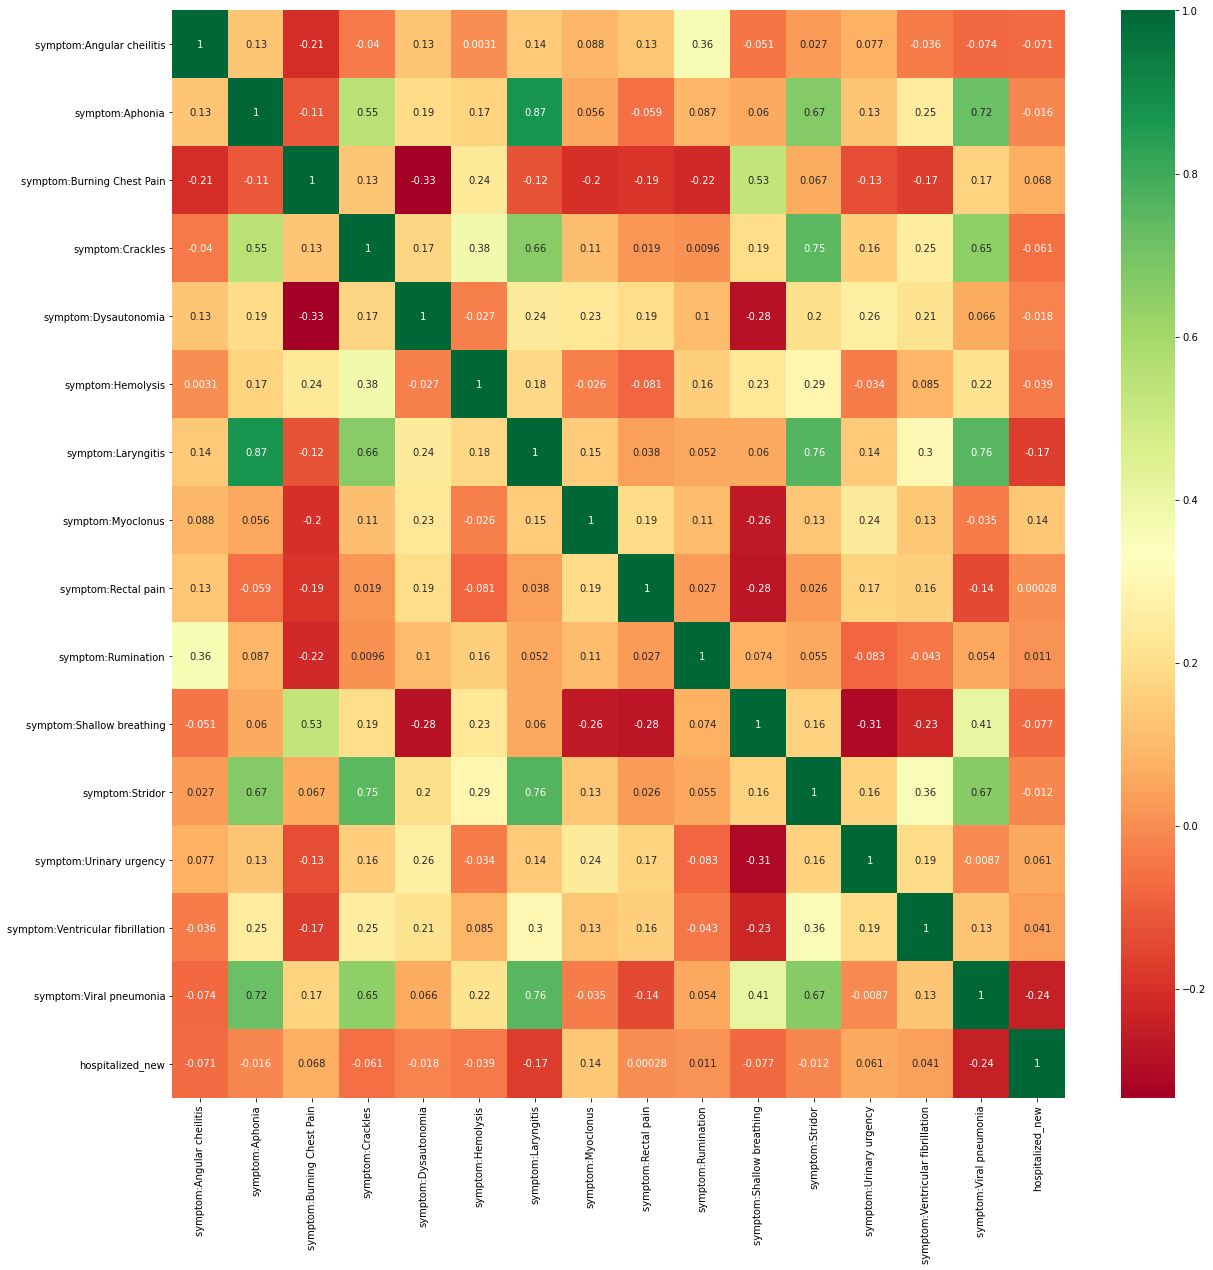

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns


X = mergedData.loc[:, mergedData.columns != 'hospitalized_new'] 
y = mergedData['hospitalized_new']    #target column i.e price range
#get correlations of each features in dataset
corrmat = mergedData.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(mergedData[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Task 2: Visualize and cluster the data

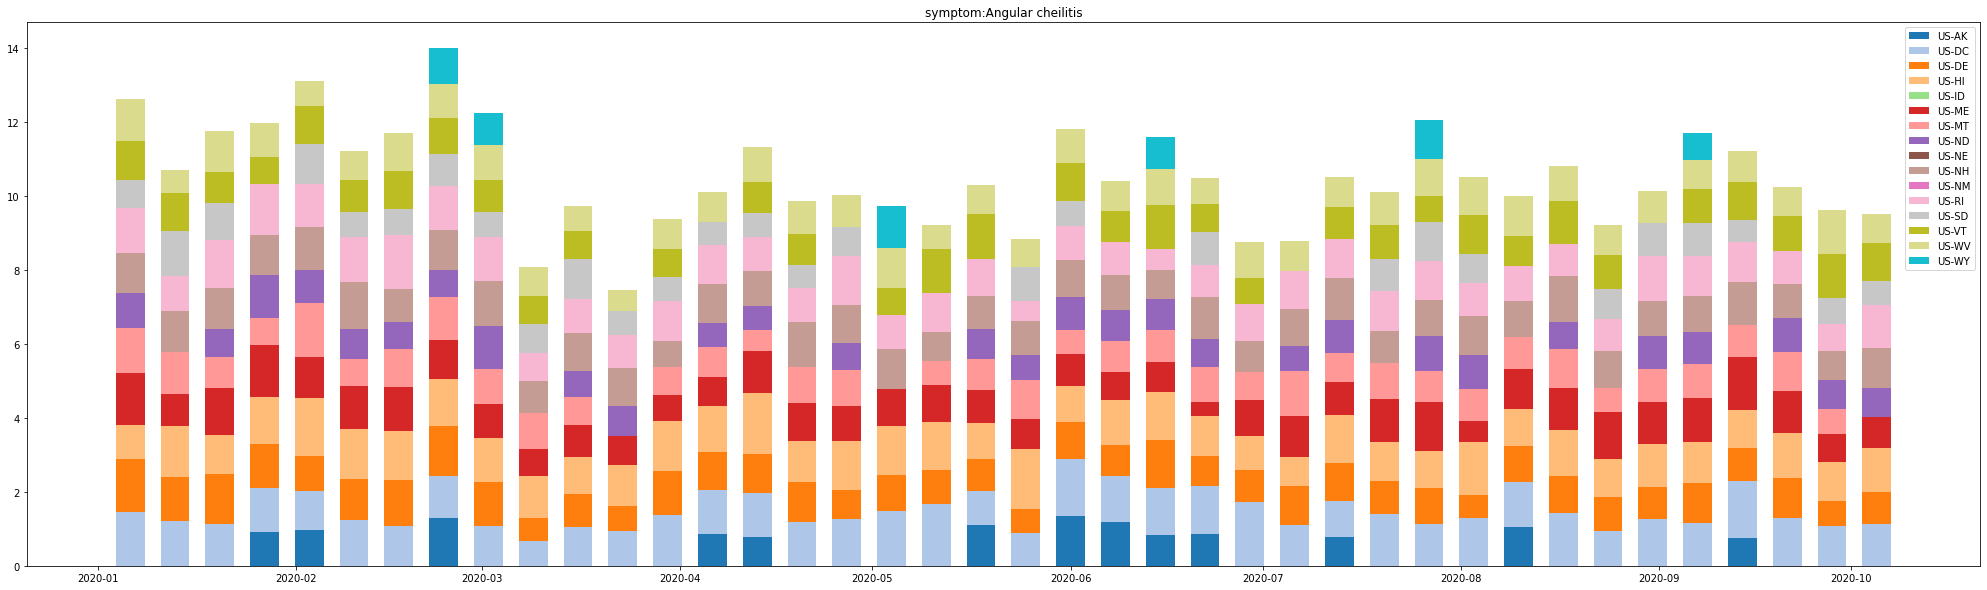

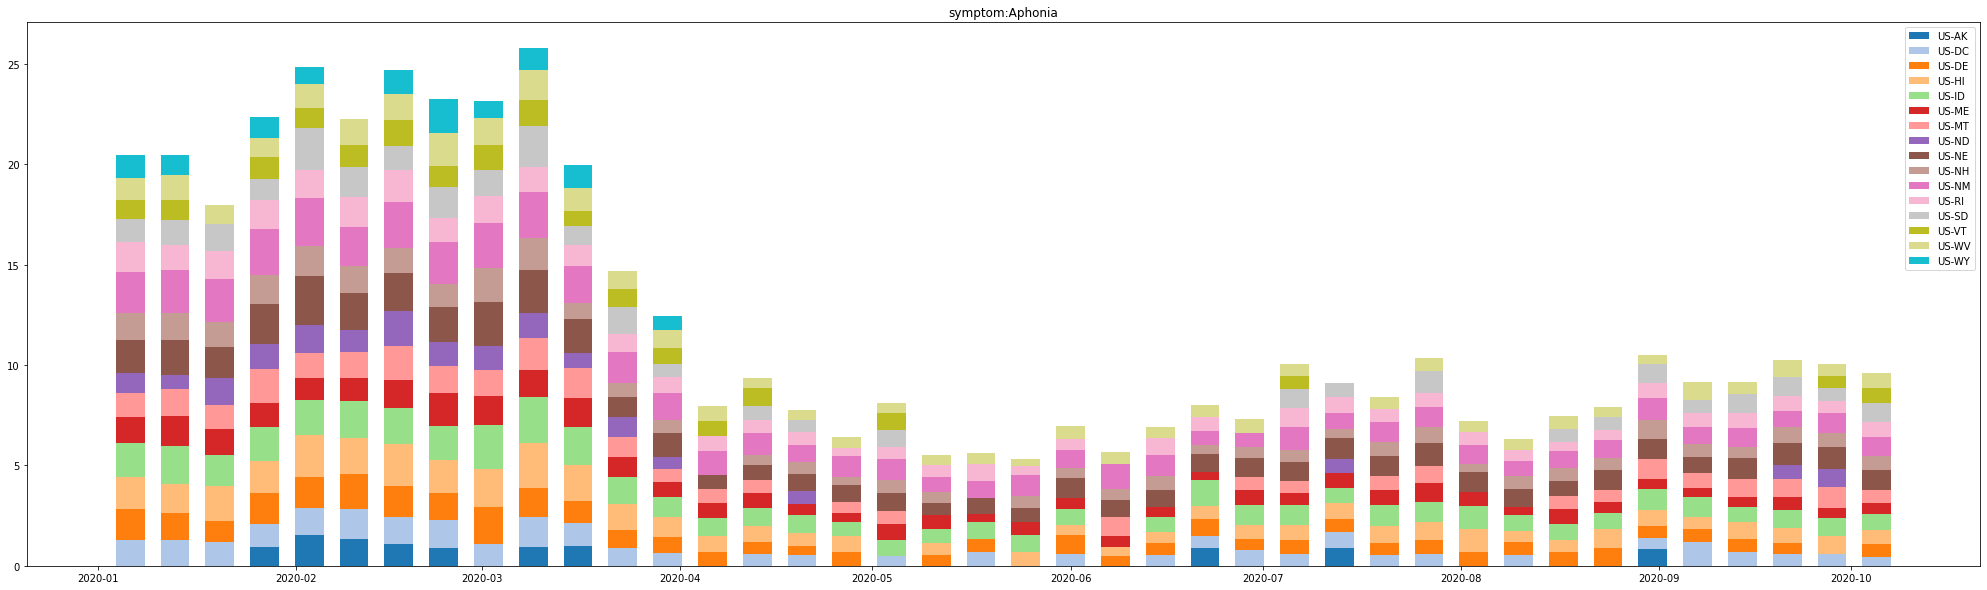

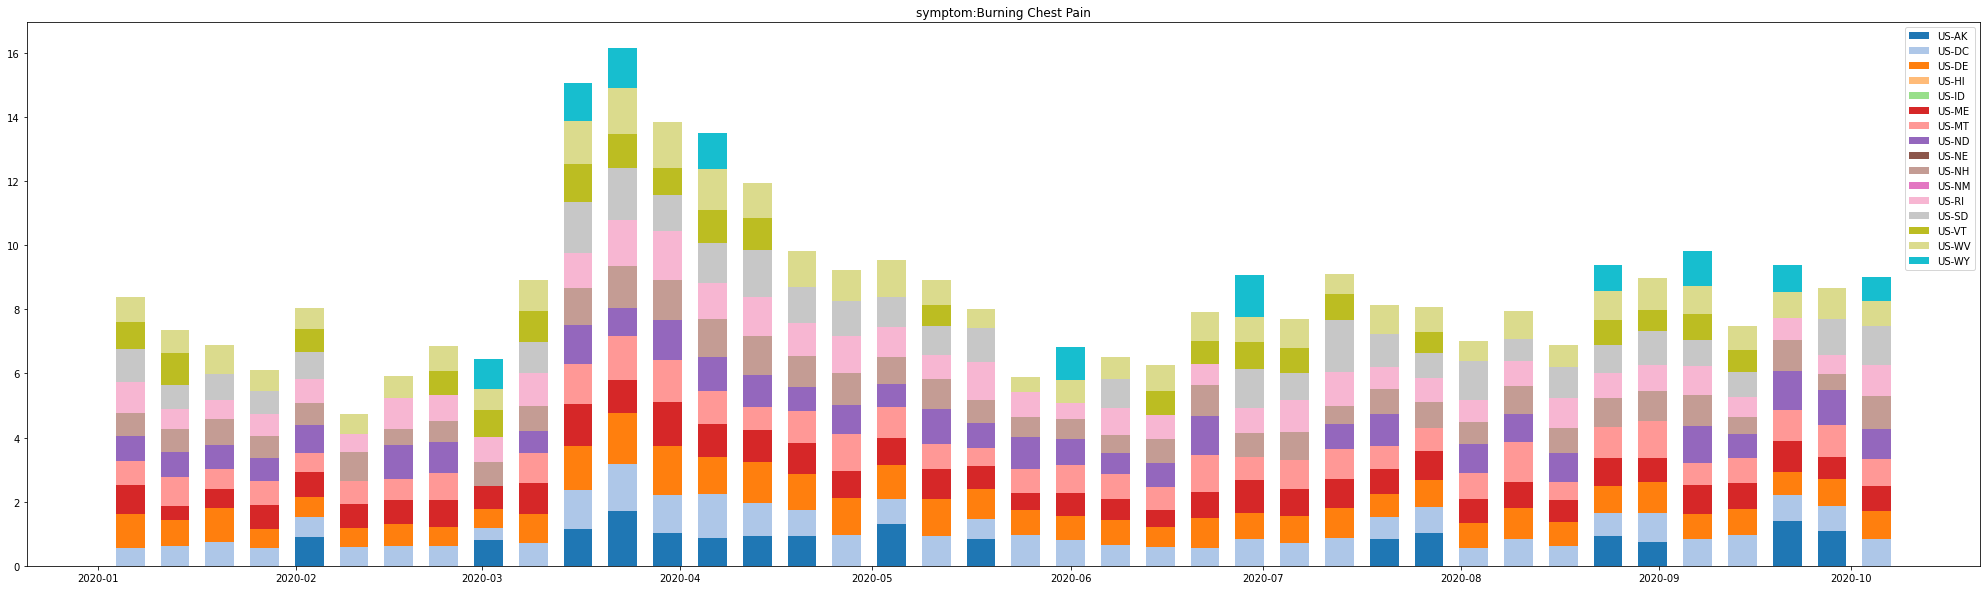

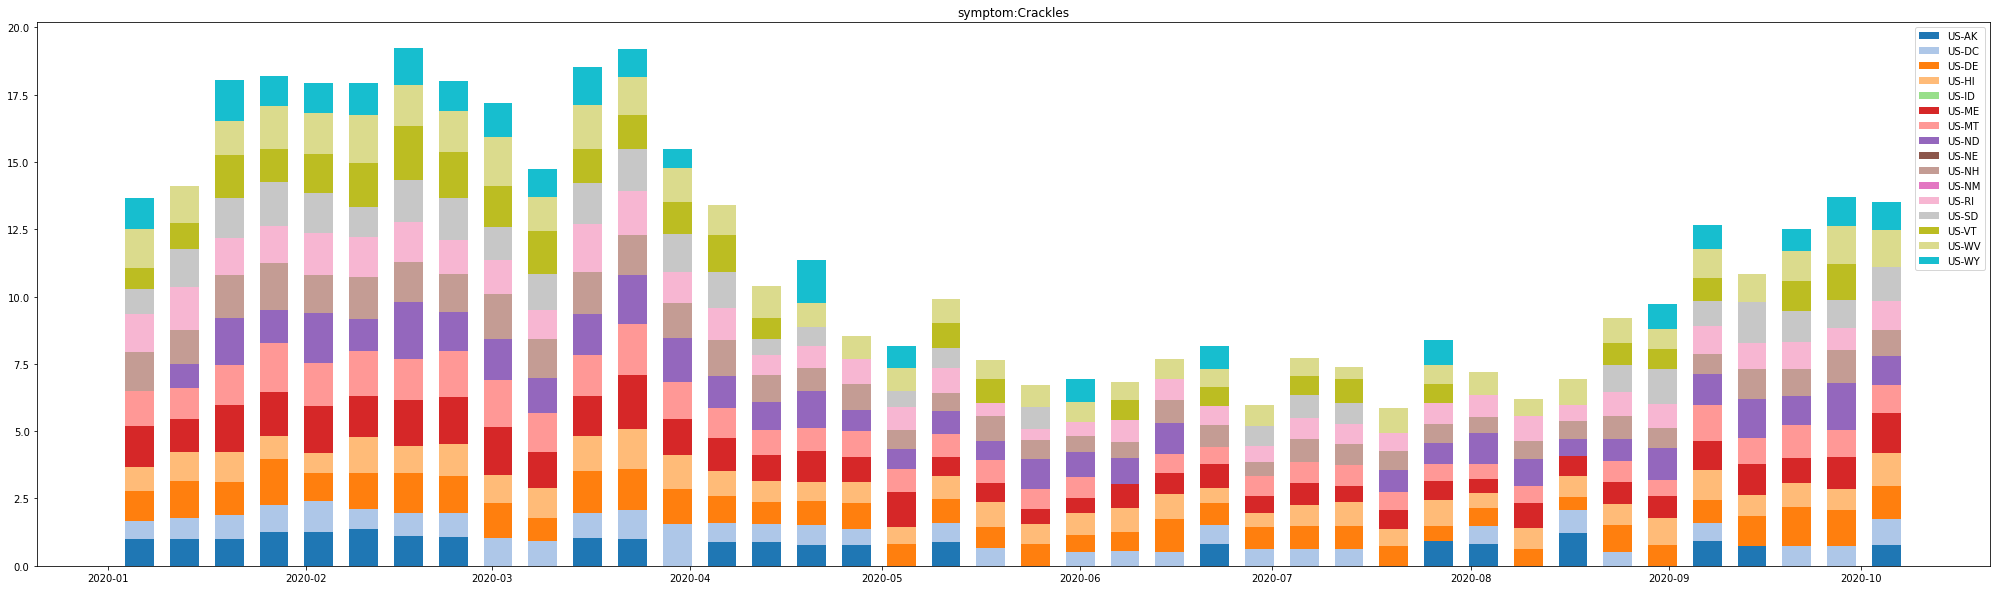

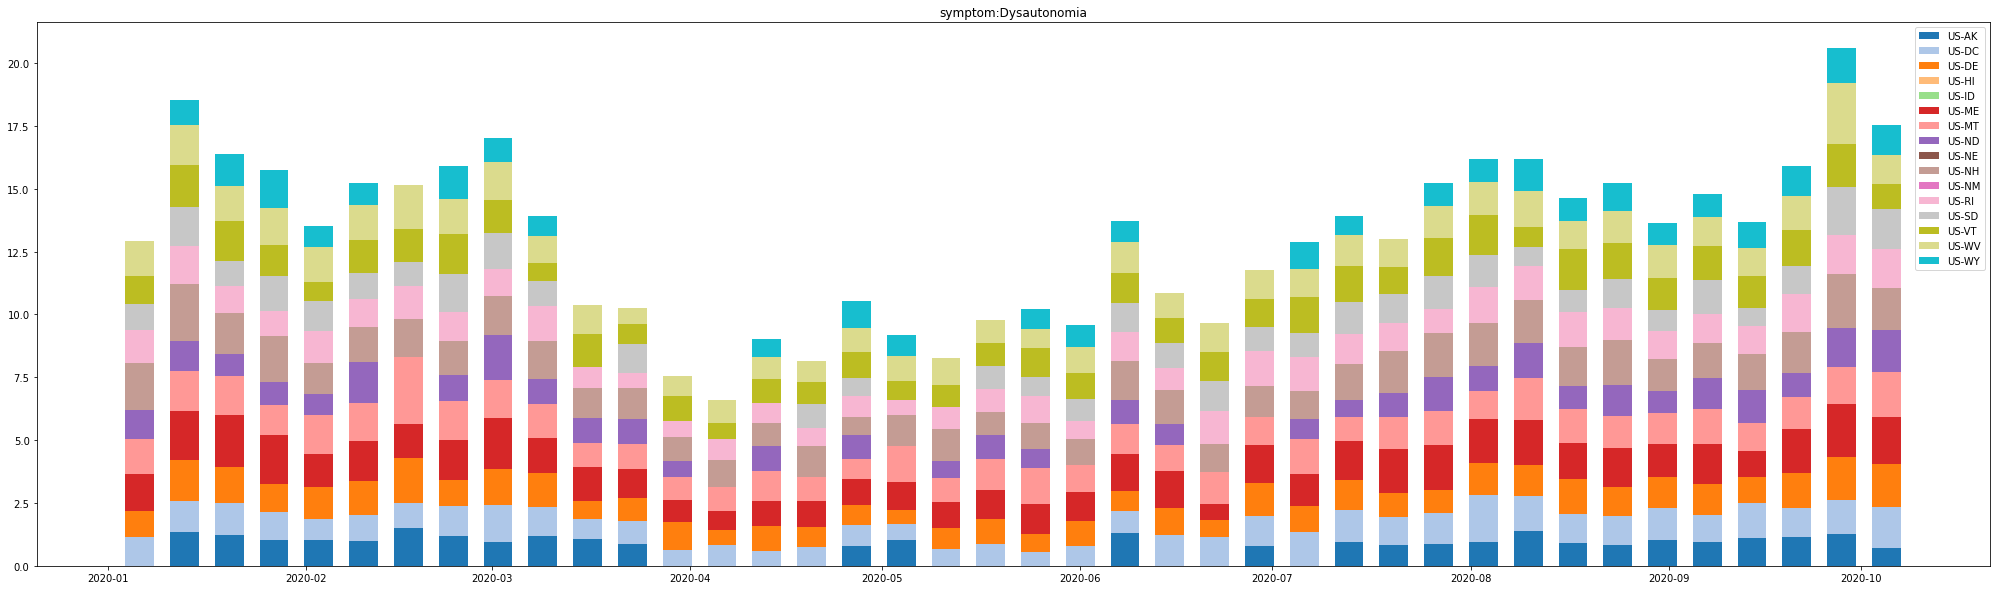

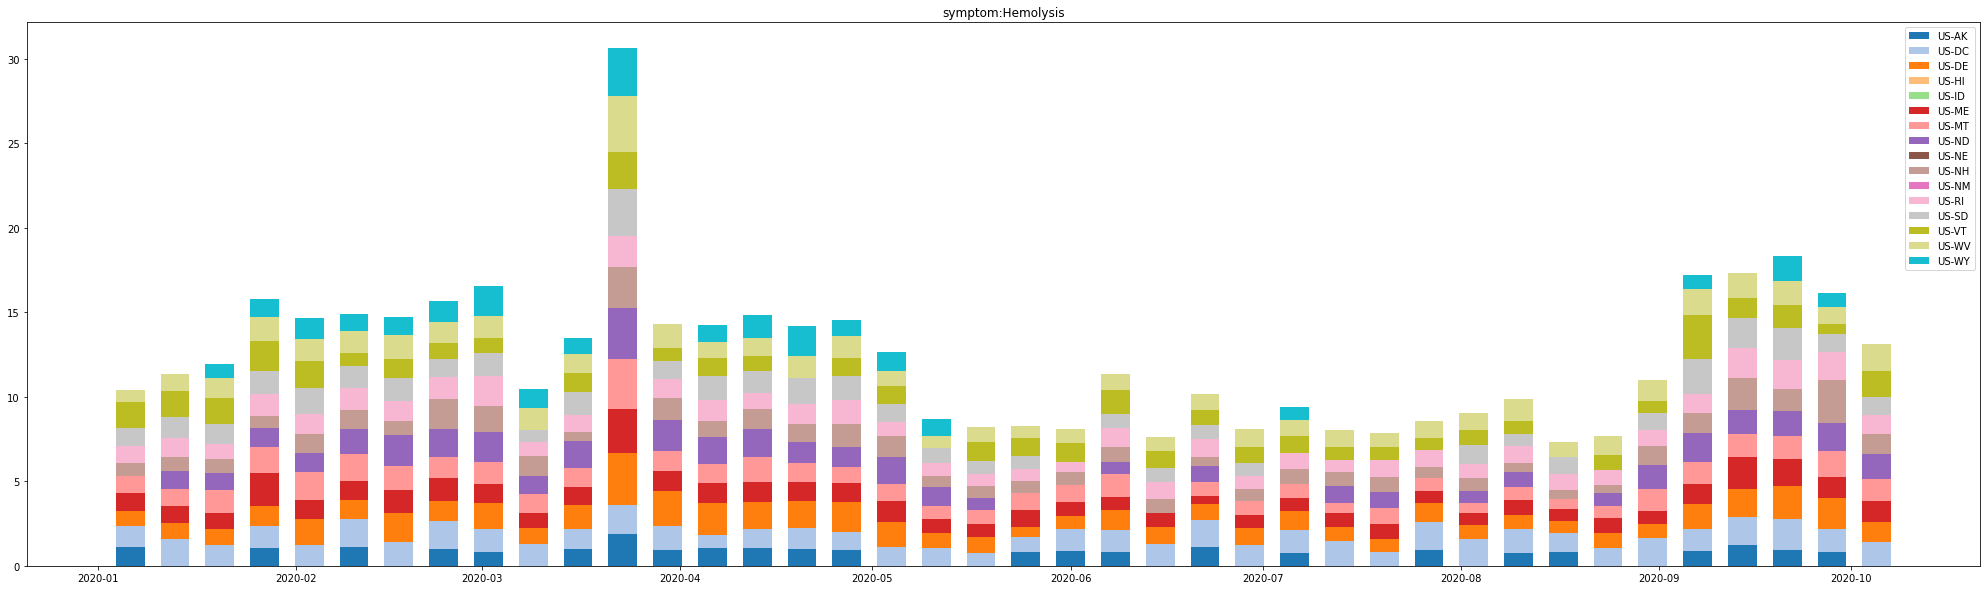

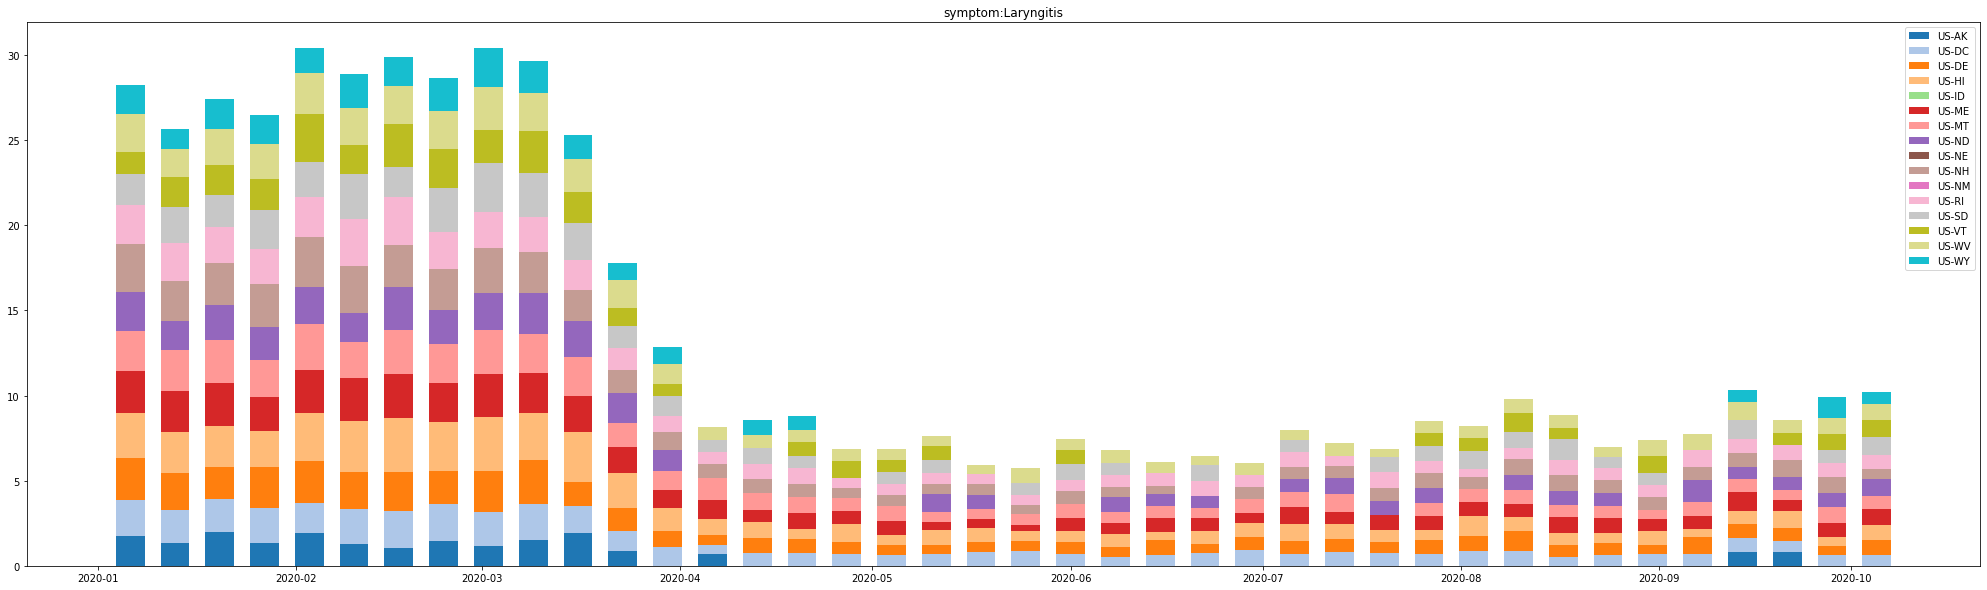

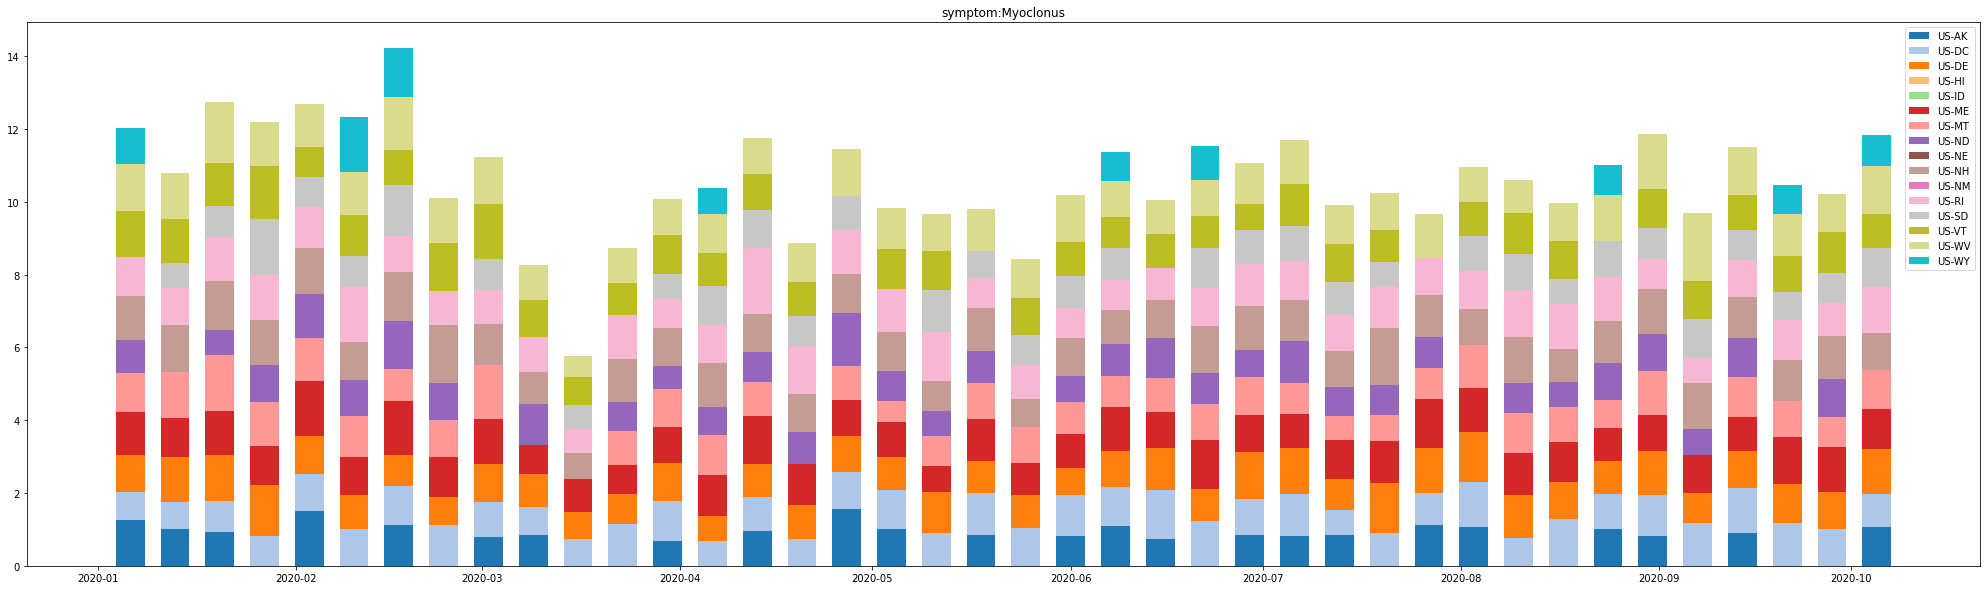

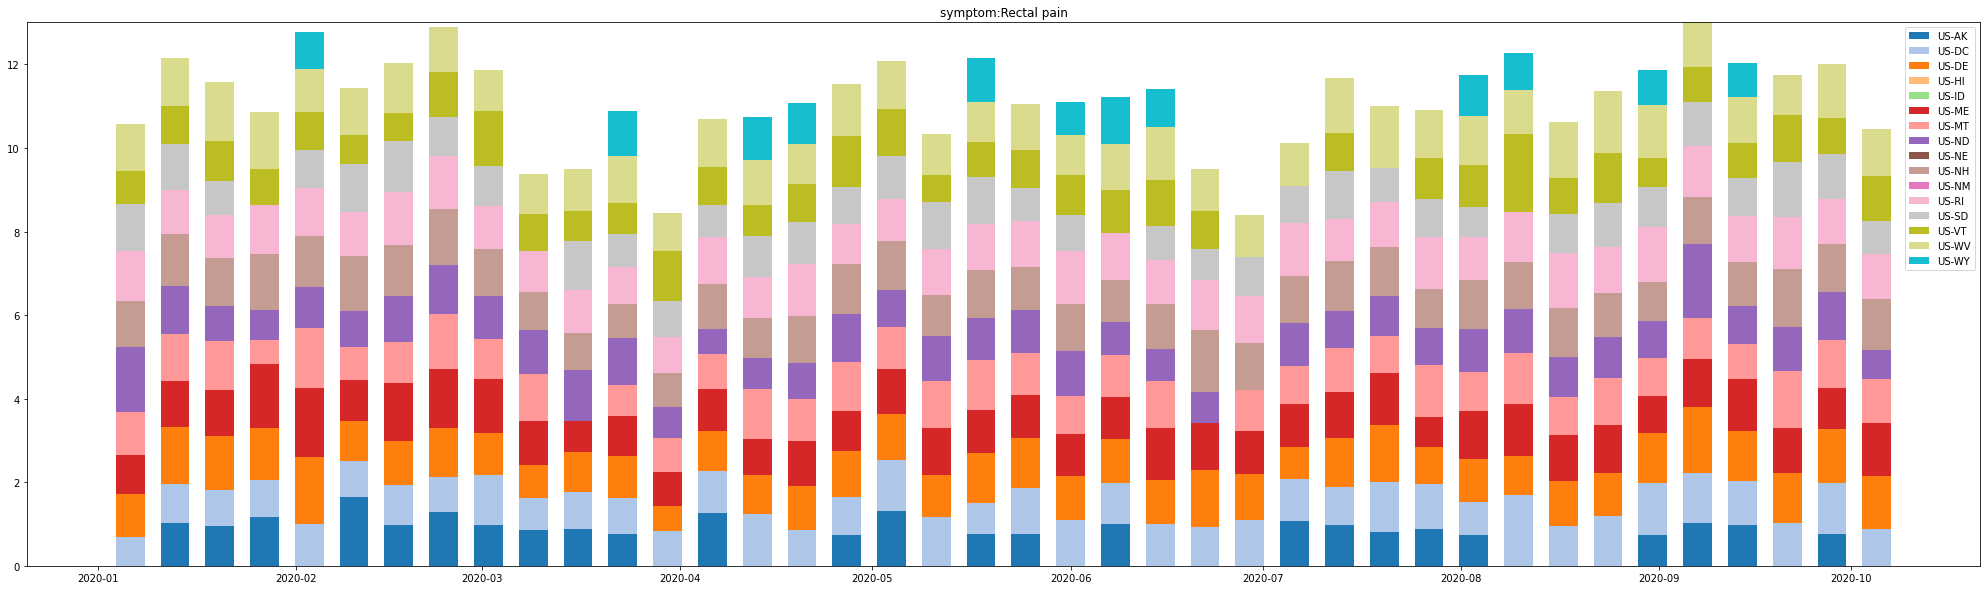

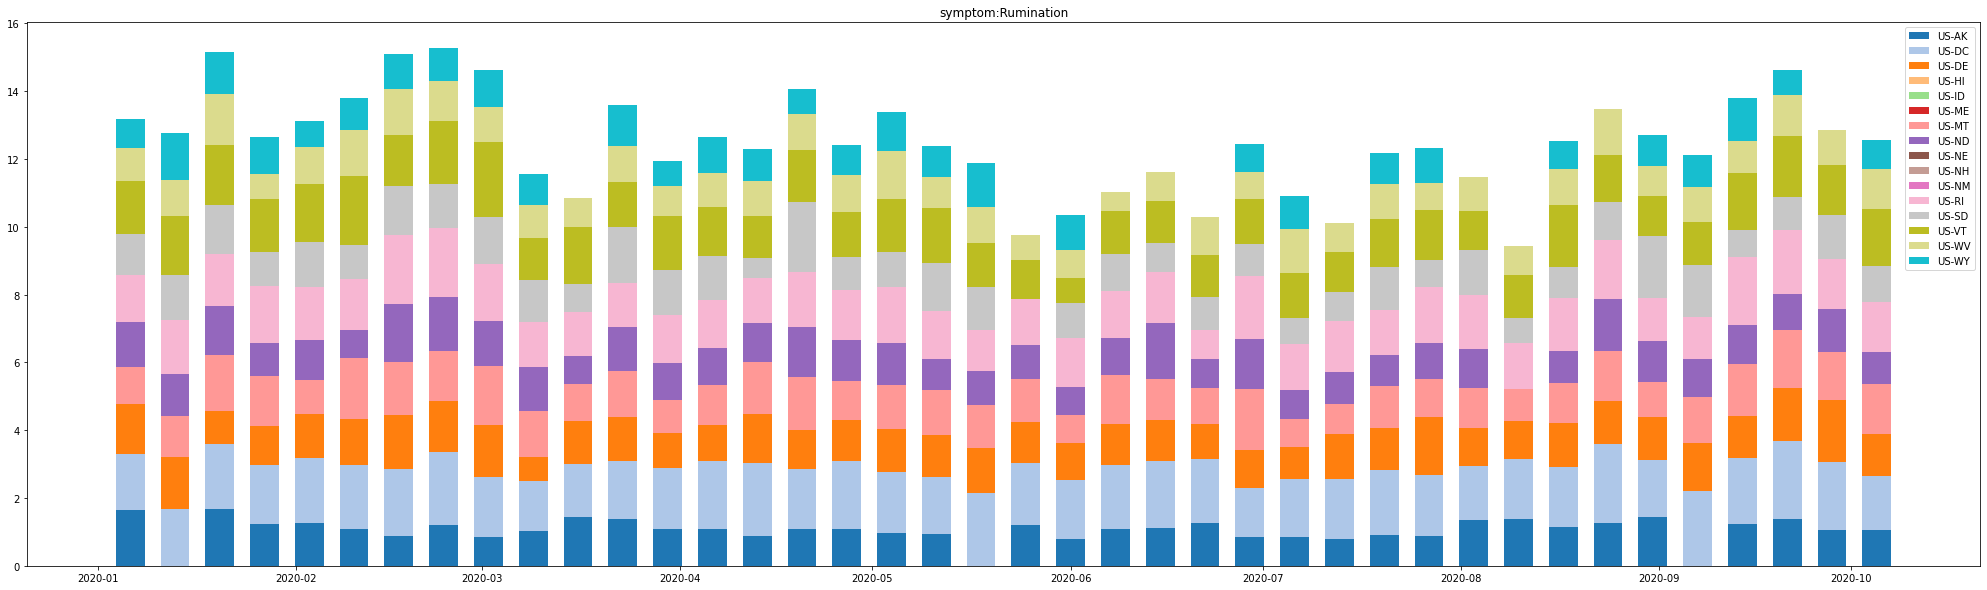

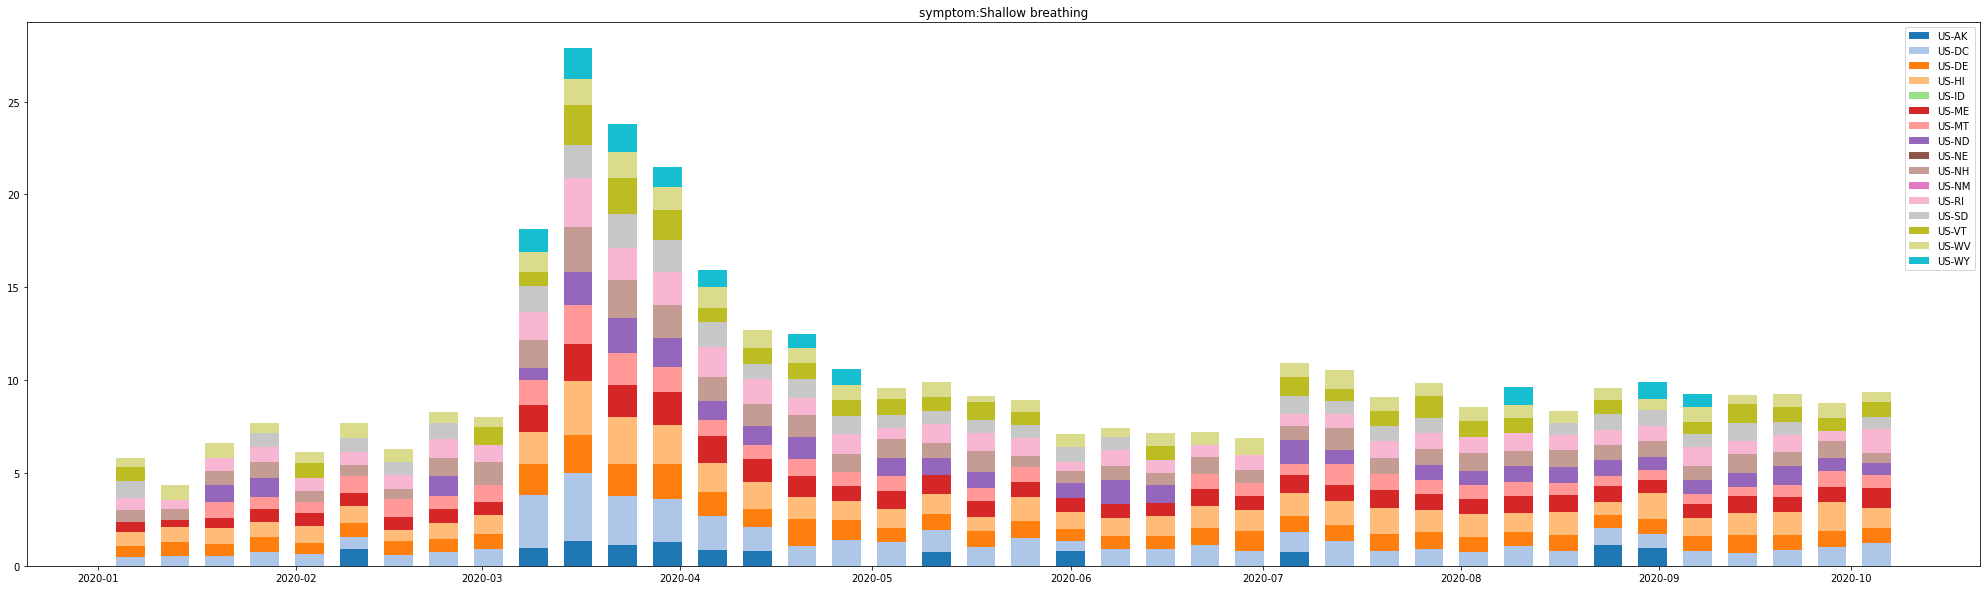

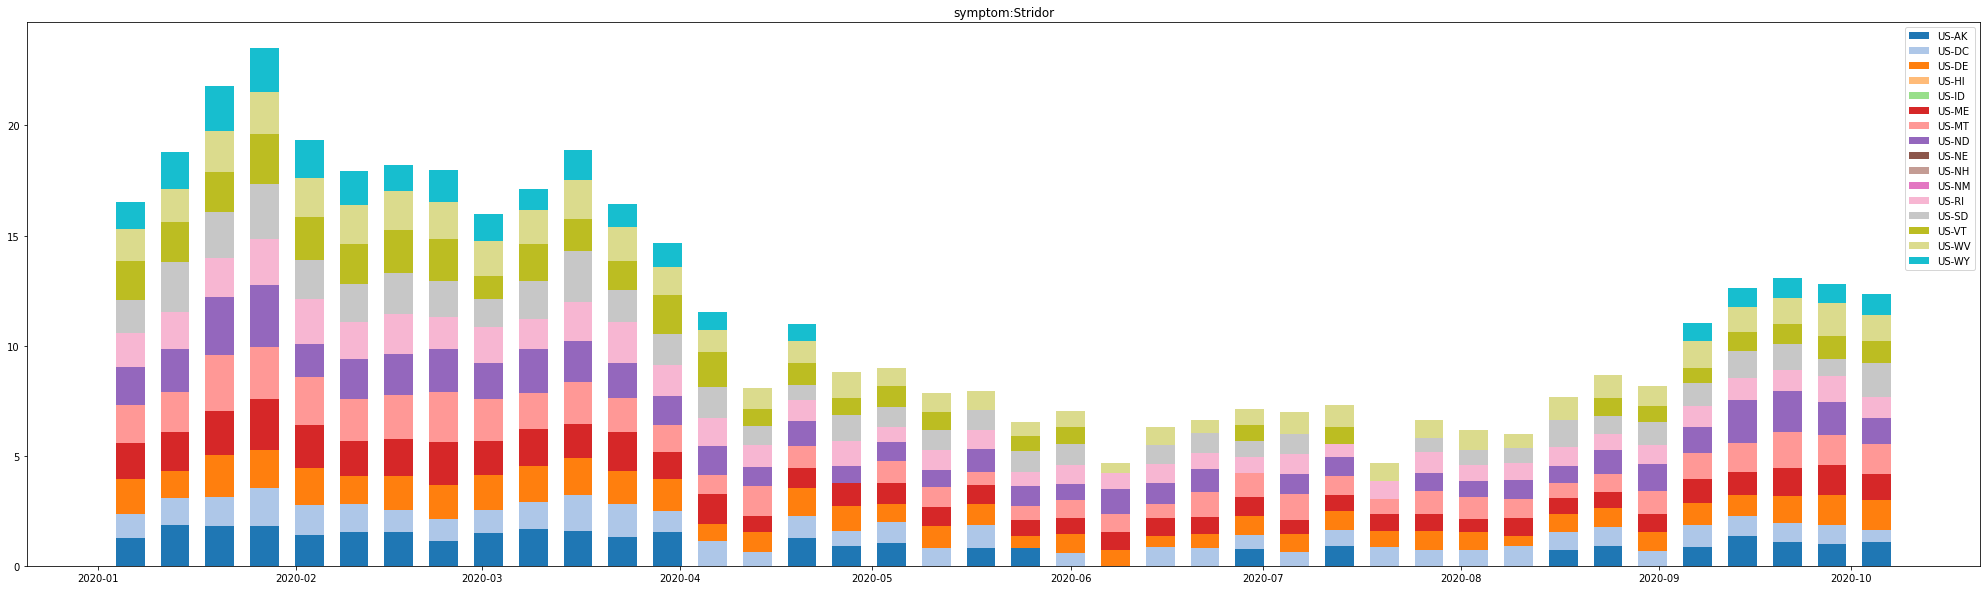

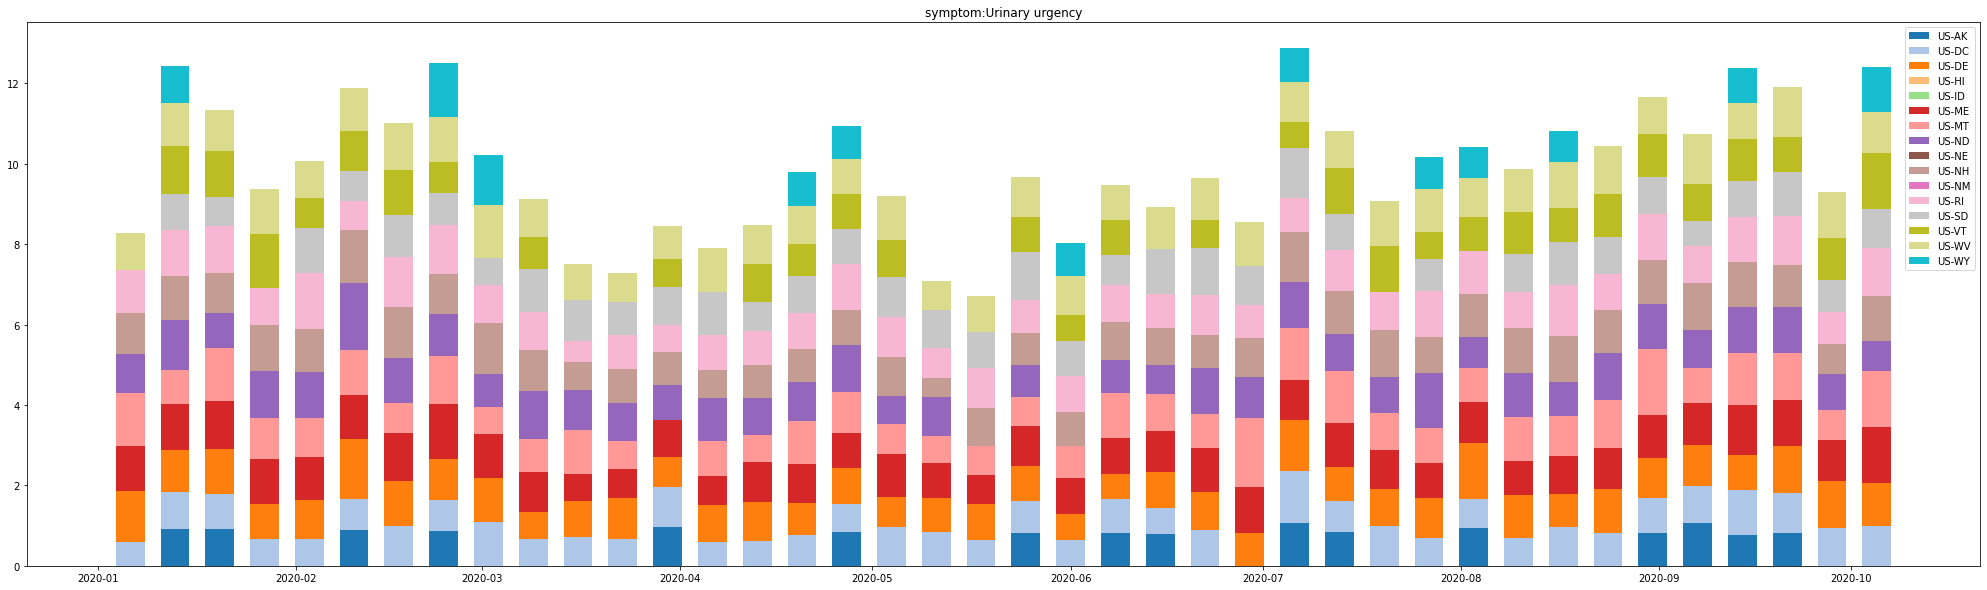

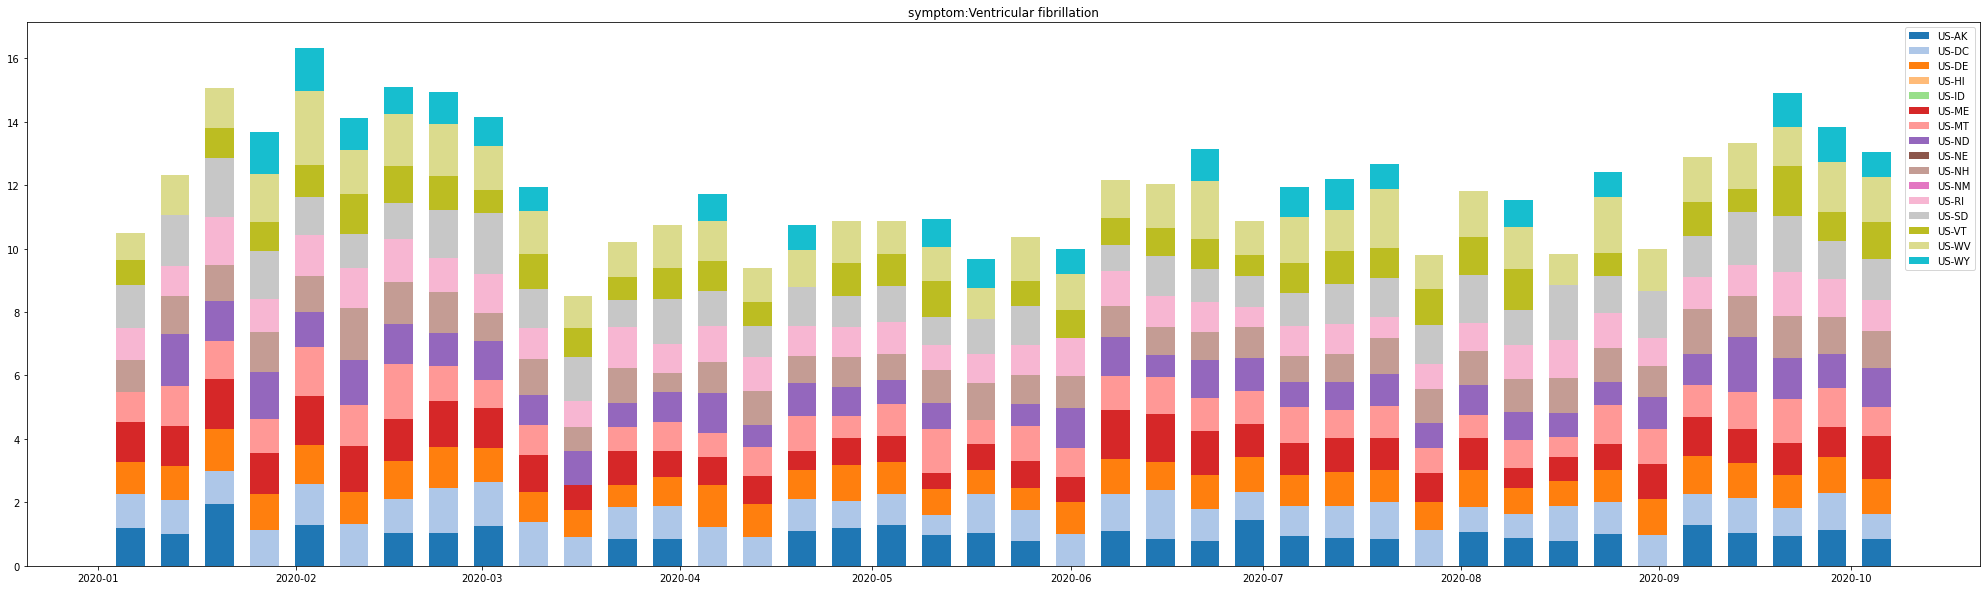

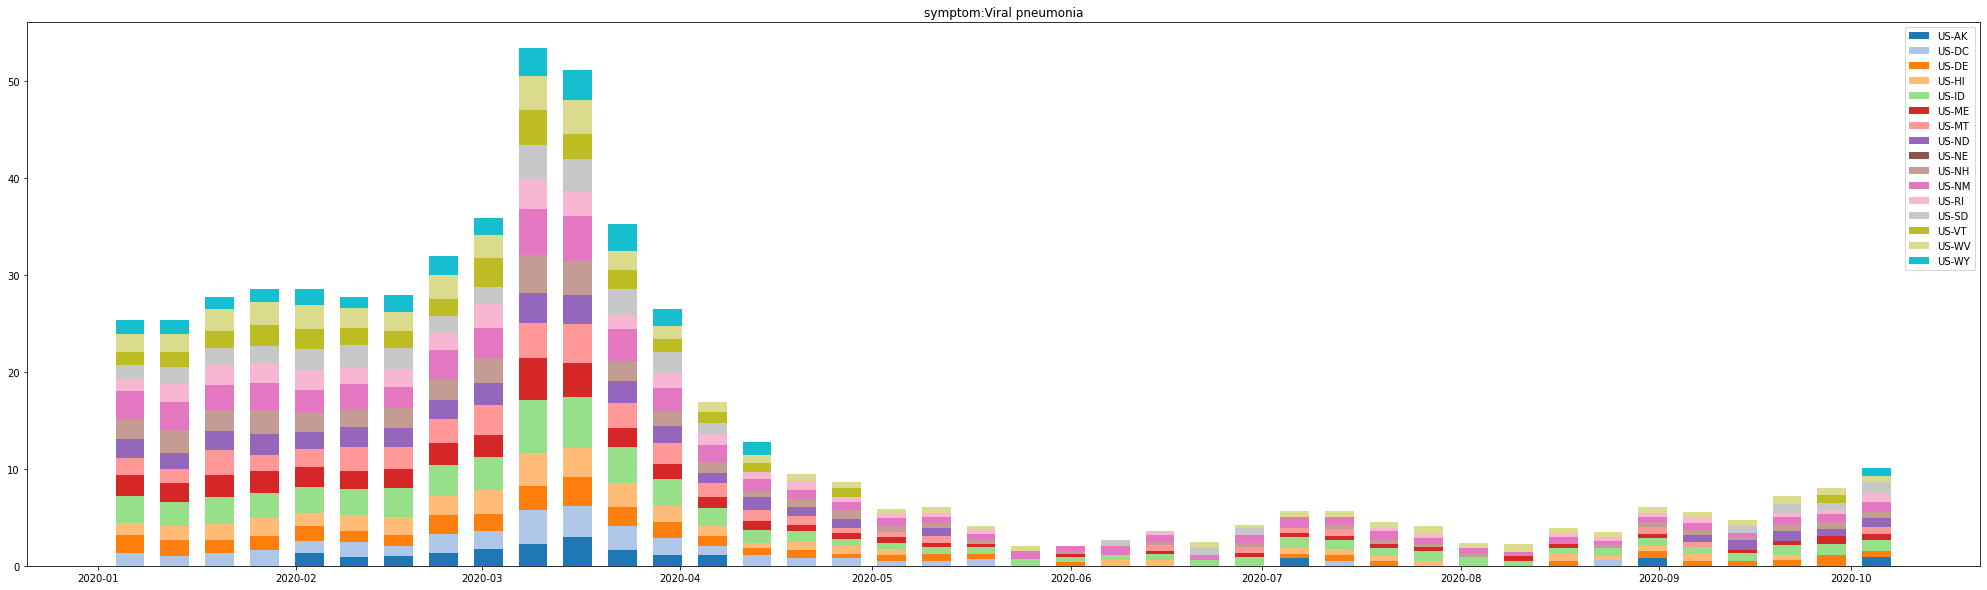

In [77]:
## extract all symptoms
symptoms = []
for column in mergedData.columns:
    type(column)
    if 'symptom' in column:
        ## column = column[8:]
        symptoms.append(column)

del column

## iteratively plot each symptoms
weeks = mergedData['date'].unique()
regions = mergedData['open_covid_region_code'].unique()
grouped_data_by_week = mergedData.groupby('date')
grouped_by_region = mergedData.groupby('open_covid_region_code')

## for each symptom, draw a graph
for symptom in symptoms:
    fig, ax = plt.subplots(figsize=(35, 10))
    NUM_COLORS = len(regions)
    color_map = plt.get_cmap('tab20')
    ax.set_prop_cycle('color', [color_map(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    width = 4.5
    ## for each region, fetch data from each week
    previous_region_week_data = [0] * len(weeks) ## the bottom for the next region rect
    for region in regions:
        region_data_all_weeks = grouped_by_region.get_group(region)[symptom].fillna(0)
        ax.set_title(symptom)
        ax.bar(weeks, region_data_all_weeks, width, previous_region_week_data, label = region)
        ax.legend()
        ## update previous data
        region_data_list =region_data_all_weeks.to_list()
        for i in range(0, len(region_data_all_weeks)):
            previous_region_week_data[i] += region_data_list[i]
    fig.savefig(symptom + "_popularity.png")
del symptoms
del weeks
del regions
del grouped_data_by_week

### PRINCIPAL COMPONENT ANALYSIS (PCA)

In [98]:
from sklearn.preprocessing import LabelEncoder

def encode_impute(data, strat):

    #** This function label encodes feature 'date', one-hot-encodes the other categorical features present in 'data' and then replaces the 
    #   missing values with the 'strat'.
    #
    #   Arguments: data = data input
    #                strat = imputation strategy (i.e mean, median, etc)
    #      
    #   Returns:  new_data = resulting data output
    #              enc = fitted one_hot_encoder
    #              imp = fitted imputer

    # Label encode the date feature
    labelencoder = LabelEncoder()
    data['date'] = labelencoder.fit_transform(data['date'])  

    # OneHotEncoding
    encoder = OneHotEncoder(sparse = False)
    features_to_be_encoded = data.select_dtypes(exclude = ['float64','int'])
    encoder.fit(features_to_be_encoded)
    encoded_features = encoder.transform(features_to_be_encoded)
    encoded_data = pd.DataFrame(encoded_features).join(data.select_dtypes(include = ['float64','int']))
    
    #Imputation
    imp = SimpleImputer(missing_values=np.nan, strategy= strat)
    imp.fit(encoded_data)
    new_data= imp.transform(encoded_data)


    return new_data, encoder, imp


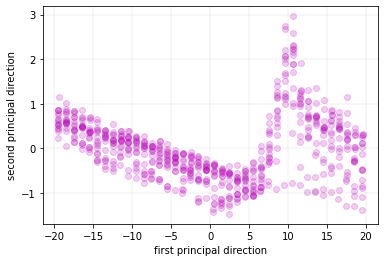

[0.96929415 0.00383341]


In [102]:
# PCA using scikit-learn

pca = PCA(n_components=2)

searchTrendDataPCA, enc, imp = encode_impute(searchTrendData, 'median')  #one-hot-encoding and mean imputation
searchTrendDataPCA = pca.fit_transform(searchTrendDataPCA)

plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], alpha=0.2, c = 'm' )
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.xlabel("first principal direction")
plt.ylabel("second principal direction")
plt.show()

print(pca.explained_variance_ratio_)

### K - Means Clustering

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def k_means(data, max_clusters):

    #  *** computes the inertia and silouette score for varying number of clusters and plots them to
    #  show the relationship.
    #   Returns the lists of inertia scores and silhouette scores

    inertia_values = []
    sil_scores = []

    for val in range(1, max_clusters):
        kmeans = KMeans(n_clusters = val, n_init = 30, init = 'k-means++')
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
        if val >= 2:
            sil_scores.append(silhouette_score(data, kmeans.labels_))

    plt.plot(range(1,max_clusters), inertia_values)
    plt.title('Selecting the optimal value of k using the elbow method')
    plt.xlabel('number of clusters')
    plt.ylabel('total sum of square differences')
    plt.show()

    plt.figure()
    plt.plot(range(2, max_clusters ), sil_scores)
    plt.title('Selecting the optimal value of k using the silhouette method')
    plt.xlabel('number of clusters')
    plt.ylabel('silhouette scores')
    plt.show()

    return inertia_values, sil_scores

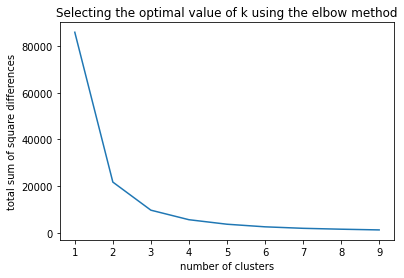

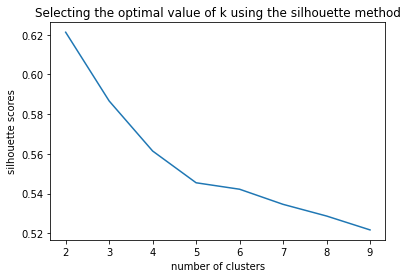

In [20]:
# Choosing the number of clusters for PCA-reduced searchtrendData, aka searchTrendDataPCA
inertia, silhouet = k_means(searchTrendDataPCA, 10)

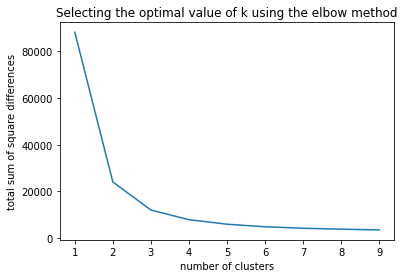

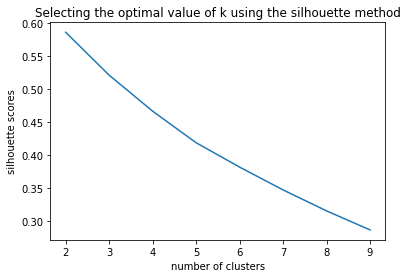

In [21]:
# Choosing the number of clusters for searchtrendData
searchTrendDataEncoded, enc, imp = encode_impute(searchTrendData, 'mean')
inertia_raw, silhouette_raw = k_means(searchTrendDataEncoded, 10 )

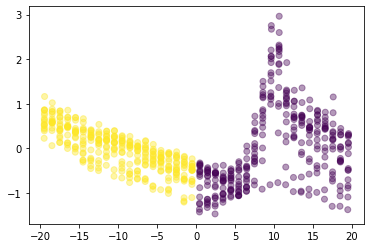

In [22]:
# choose 2 based on the silhouette and the elbow method
kmeans = KMeans(n_clusters = 2, n_init = 30, init = 'k-means++')
prediction = kmeans.fit_predict(searchTrendDataPCA)
plt.scatter(searchTrendDataPCA[:,0], searchTrendDataPCA[:,1], c=prediction, alpha=0.4)

# Task 3: Supervised Learning

## 1. Splitting the data into train and validation based on time or based on regions

In [23]:
## a function that splits the dataset into 80% training set and 20% validation set
def split_dataset_on(dataset, on):
    gss = GroupShuffleSplit(n_splits = 2, train_size = 0.8)
    training, validation = next(gss.split(dataset, groups = dataset[on]))
    training_set = dataset.iloc[training]
    validation_set = dataset.iloc[validation]
    return training_set, validation_set

training_set_region, validation_set_region = split_dataset_on(mergedData, 'open_covid_region_code')
training_set_time, validation_set_time = split_dataset_on(mergedData, 'date')

## 2. Regression performance comparison between KNNs and Decision Trees

DECISION TREES

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# I don't think we need the 'index' and 'region_name' columns from the hospitalization dataset in the mergedData
# LFY: Feel free to drop them if you want
data = mergedData.drop(['index', 'region_name'], axis=1)

## since hospitalized_new is our target, we take regions with valid entries in hospitalized_new.
data = data[data['hospitalized_new'].notna()]



/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

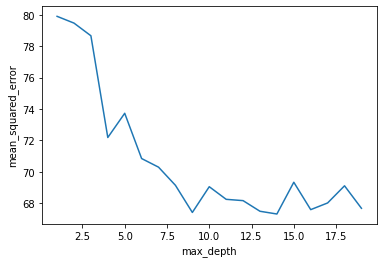

In [82]:
# FINDING THE OPTIMUM MAX_DEPTH

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt


X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
#print('encoded shape', data_new.shape)

y = data['hospitalized_new']

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=113)


results_ = []
for d in range(1,20):
    
    tree = DecisionTreeRegressor(max_depth=d)
    model = tree.fit(train_x, train_y)
    

    # ****** ASSESSING PERFORMANCE ********
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

plt.plot(range(1,20), results_)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')


REGION BASED SPLIT WITH 5-FOLD CROSS-VALIDATION

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


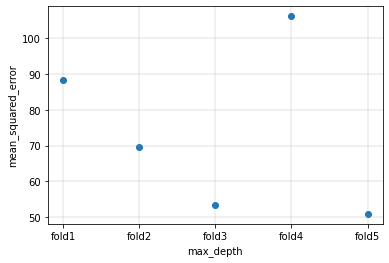

In [83]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['open_covid_region_code']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]

    tree = DecisionTreeRegressor(max_depth=9)
    model = tree.fit(train_x, train_y)

    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')
plt.show()


TIME BASED SPLIT

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

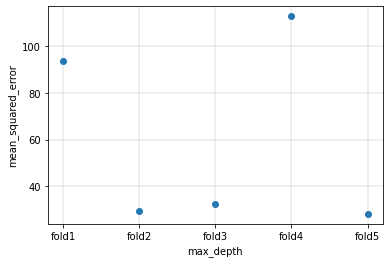

In [84]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['date']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]

    tree = DecisionTreeRegressor(max_depth=9)
    model = tree.fit(train_x, train_y)

    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))

    results_.append(error)

folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

#### KNN

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
RMSE value for k =  1 is: 58.26879462615016
RMSE value for k =  2 is: 65.1049749788009
RMSE value for k =  3 is: 51.170980600956156
RMSE value for k =  4 is: 47.13464497884283
RMSE value for k =  5 is: 47.652162004355276
RMSE value for k =  6 is: 45.32684847963742
RMSE value for k =  7 is: 42.77218347264069
RMSE value for k =  8 is: 41.64866560992535
RMSE value for k =  9 is: 40.352648116281095
RMSE value for k =  10 is: 41.048008832660976
RMSE value for k =  11 is: 40.69092754768173
RMSE value for k =  12 is: 40.83649432980002
RMSE value for k =  13 is: 40.837745914215844
RMSE value for k =  14 is: 40.87340793866723
RMSE value for k =  15 

Text(0, 0.5, 'mean_squared_error')

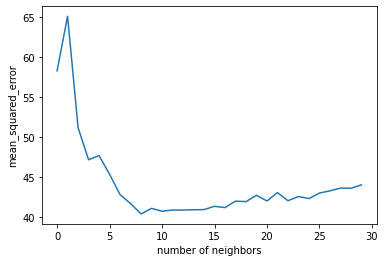

In [86]:
# FINDING THE OPTIMAL K


from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
#print('encoded shape', data_new.shape)

y = data['hospitalized_new']

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=193)

rmse_val = []

for K in range(30):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    rmse_val.append(error)
    print('RMSE value for k = ',K,'is:',error)


plt.plot(range(30), rmse_val)
plt.xlabel('number of neighbors')
plt.ylabel('mean_squared_error')


KNN - REGION BASED CROSS-VALIDATION using optimal k from above

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

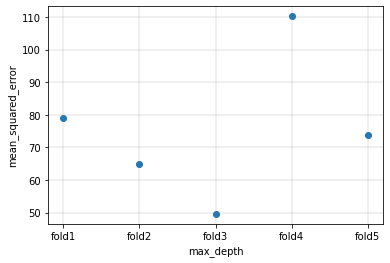

In [88]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['open_covid_region_code']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]

    model = neighbors.KNeighborsRegressor(n_neighbors = 9)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    results_.append(error)
    


folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

KNN, DATE BASED CROSS-VALIDATION

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0, 0.5, 'mean_squared_error')

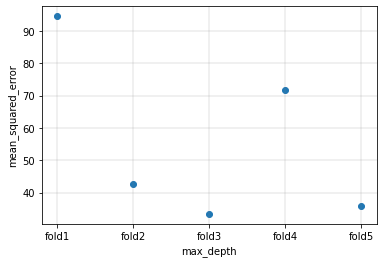

In [90]:
from sklearn.model_selection import GroupKFold

X, enc, imp = encode_impute(data.loc[:, data.columns != 'hospitalized_new'], 'mean')
y = data['hospitalized_new']
groups = data['date']

gkf = GroupKFold(n_splits=5)
results_ = []

for train_index, test_index in gkf.split(X, y, groups=groups):
    train_x, valid_x, train_y, valid_y = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]

    model = neighbors.KNeighborsRegressor(n_neighbors = 9)
    model.fit(train_x, train_y)
    result = model.predict(valid_x)
    error = sqrt(mean_squared_error(valid_y,result))
    results_.append(error)
    


folds = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5']
plt.scatter(folds, results_)
plt.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.9)
plt.xlabel('max_depth')
plt.ylabel('mean_squared_error')

### Creative Experiment - Linear Regression on Symptoms vs New Hospitalization

##### Determine if a strong correlation exists between a symptom and likelihood of being admitted to the hospital because of it 

The correlation coefficient between symptom:Angular cheilitis and Hospitalized_New is: 19.321660536387718
The correlation coefficient between symptom:Aphonia and Hospitalized_New is: -33.01005415636133
The correlation coefficient between symptom:Burning Chest Pain and Hospitalized_New is: 30.369127465725775
The correlation coefficient between symptom:Crackles and Hospitalized_New is: -30.886464288377958
The correlation coefficient between symptom:Dysautonomia and Hospitalized_New is: -21.919055954333455
The correlation coefficient between symptom:Hemolysis and Hospitalized_New is: -21.264386024953883
The correlation coefficient between symptom:Laryngitis and Hospitalized_New is: -25.509443399319974
The correlation coefficient between symptom:Myoclonus and Hospitalized_New is: 129.2083188522759
The correlation coefficient between symptom:Rectal pain and Hospitalized_New is: -42.43573759334653
The correlation coefficient between symptom:Rumination and Hospitalized_New is: 24.607419915440

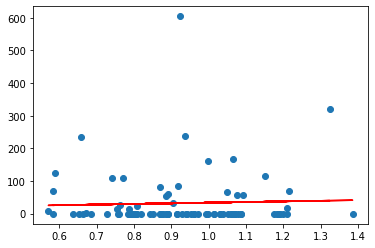

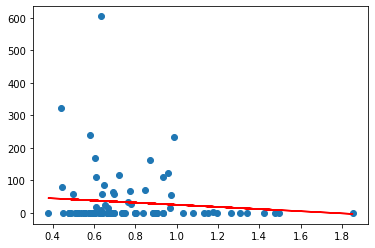

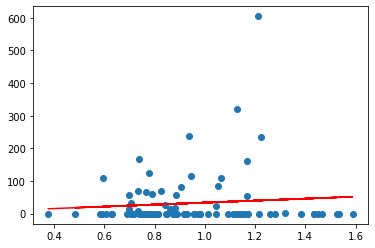

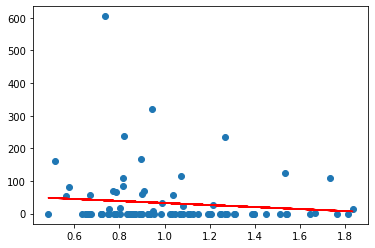

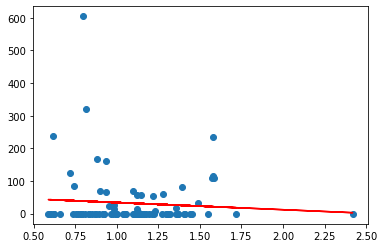

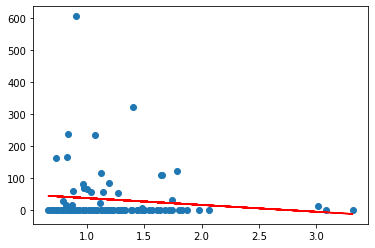

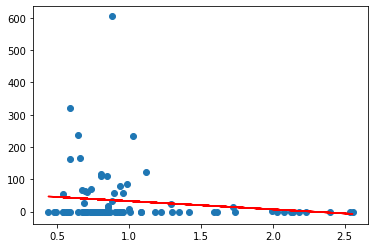

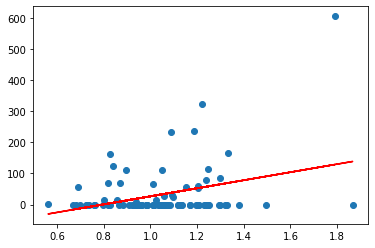

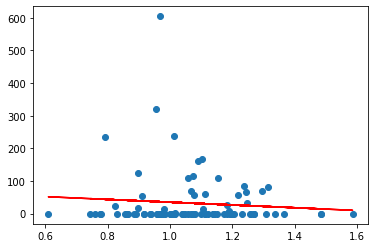

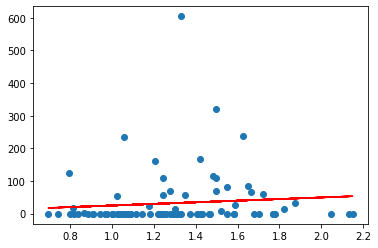

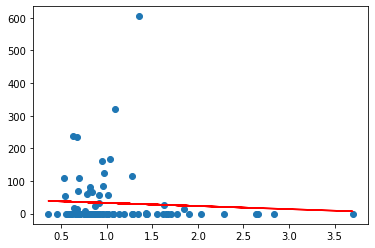

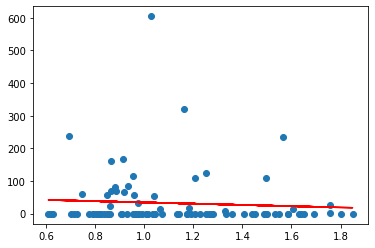

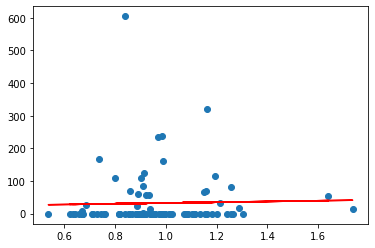

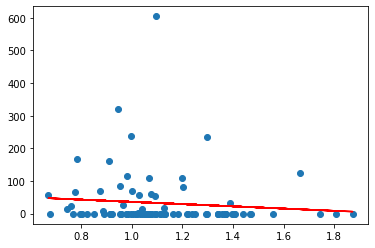

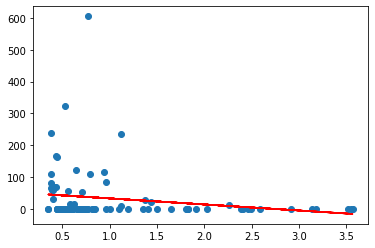

In [74]:
from sklearn.linear_model import LinearRegression
symptoms = []
mergedDatana = mergedData.dropna()
for i in mergedDatana.columns:
    if 'symptom' in i:
        symptoms.append(i)


count = 0
for i in symptoms:
    X = mergedDatana[i].values.reshape(-1,1)
    Y = mergedDatana['hospitalized_new'].values.reshape(-1,1)
    lr = LinearRegression().fit(X, Y)
    Y_pred = lr.predict(X)
    plt.figure(count)
    plt.scatter(X,Y)
    plt.plot(X, Y_pred, color='red')
    r = lr.coef_
    print("The correlation coefficient between " + i + " and Hospitalized_New is: " + str(r[0][0]))
    count += 1
